<a href="https://colab.research.google.com/github/arinaruck/RL2021/blob/main/rak_arina_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Part I: On-policy learning and SARSA (3 points)](#Part-I:-On-policy-learning-and-SARSA-(3-points))

[Part II: Experience replay (4 points)](#Part-II:-experience-replay-(4-points))

[Bonus I: TD($ \lambda $) (5+ points)](#Bonus-I:-TD($\lambda$)-(5+-points))

[Bonus II: More pacman (5+ points)](#Bonus-II:-More-pacman-(5+-points))

## Part I: On-policy learning and SARSA (3 points)

_This notebook builds upon `qlearning.ipynb`, or to be exact your implementation of QLearningAgent._

The policy we're gonna use is epsilon-greedy policy, where agent takes optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You can copy your `QLearningAgent` implementation from previous notebook.

In [ ]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max([self.get_qvalue(state, a) for a in possible_actions])

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        prev_q = self.get_qvalue(state, action)
        value = self.get_value(next_state)

        self.set_qvalue(state, action, (1 - learning_rate) * prev_q + 
                        learning_rate * (reward + gamma * value) )

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action = None
        for action in possible_actions:
            q = self.get_qvalue(state, action)
            if best_action is None or q > q_max:
                q_max = q
                best_action = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        best_action = self.get_best_action(state)

        if np.random.rand() < 1 - epsilon:
            return best_action
        chosen_action = np.random.choice(possible_actions)
        return chosen_action

Now we gonna implement Expected Value SARSA on top of it.

In [ ]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        n_actions = len(possible_actions)
        best_action = self.get_best_action(state)
        random_action_prob = self.epsilon / n_actions
        best_action_prob = random_action_prob + (1 - self.epsilon)
        value = sum([self.get_qvalue(state, a) * best_action_prob if a == best_action else
                     self.get_qvalue(state, a) * random_action_prob
                     for a in possible_actions])

        return value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>image by cs188</i></center>

In [ ]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    


In [ ]:
# Our cliffworld has one difference from what's on the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [ ]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [ ]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [ ]:
agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -27.6
QLEARNING mean reward = -97.75


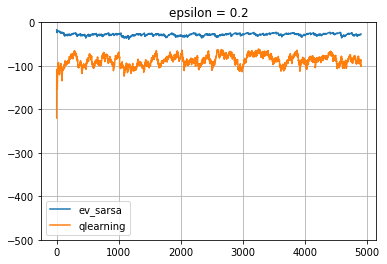

In [ ]:
rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [ ]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [ ]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  v  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


### More on SARSA

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Expected Value SARSA for softmax policy __(2pts)__:
$$ \pi(a_i \mid s) = \operatorname{softmax} \left( \left\{ {Q(s, a_j) \over \tau} \right\}_{j=1}^n \right)_i = {\operatorname{exp} \left( Q(s,a_i) / \tau \right)  \over {\sum_{j}  \operatorname{exp} \left( Q(s,a_j) / \tau  \right)}} $$
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/RLbook2020.pdf) chapter 7 and chapter 12.
* Use those algorithms to train on CartPole in previous / next assignment for this week.

In [ ]:
def eps_exp(epsilon):
    agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

    agent_ql = QLearningAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

    rewards_sarsa, rewards_ql = [], []

    for i in range(5000):
        rewards_sarsa.append(play_and_train(env, agent_sarsa))
        rewards_ql.append(play_and_train(env, agent_ql))
        # Note: agent.epsilon stays constant

        if i % 100 == 0:
            clear_output(True)
            print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
            print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
            plt.title("epsilon = %s" % agent_ql.epsilon)
            plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
            plt.plot(moving_average(rewards_ql), label='qlearning')
            plt.grid()
            plt.legend()
            plt.ylim(-500, 0)
            plt.show()
    print("Q-Learning")
    draw_policy(env, agent_ql)

    print("SARSA")
    draw_policy(env, agent_sarsa)

EVSARSA mean reward = -21.4
QLEARNING mean reward = -44.08


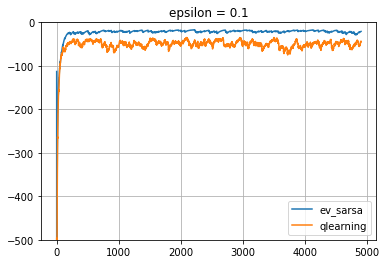

Q-Learning
 >  >  >  v  >  v  >  v  v  v  v  v 
 v  v  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
eps_exp(0.1)

EVSARSA mean reward = -92.1
QLEARNING mean reward = -242.11


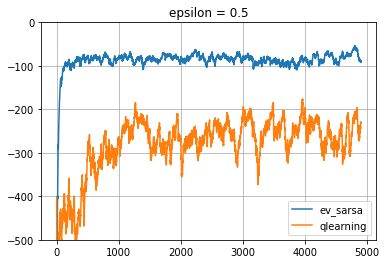

Q-Learning
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
eps_exp(0.5)

EVSARSA mean reward = -892.42
QLEARNING mean reward = -1386.15


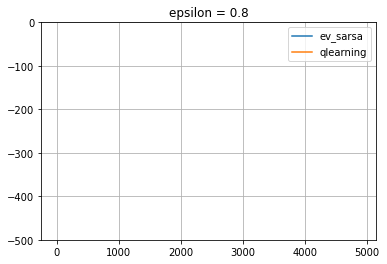

Q-Learning
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
eps_exp(0.8)

Q-learning is off-policy therefore is not sensitive to epsison chenges, SARSA, on the other hand tends to choose a more secure (further from the cliff) with the increase of epsilon

In [ ]:
def softmax(z, tau):
    e_x = np.exp(z / tau)
    div = np.sum(e_x)
    return e_x / div


class EVSarsaAgentSoftmax(EVSarsaAgent):
    def __init__(self, alpha, discount, get_legal_actions, tau):
        super().__init__(alpha, 0., discount, get_legal_actions)
        self.tau = tau

    def get_action(self, state):
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        probs = softmax(np.array([self.get_qvalue(state, a) for a in possible_actions]), self.tau)
        chosen_action = np.random.choice(possible_actions, p=probs)
        return chosen_action


    def get_value(self, state):
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        n_actions = len(possible_actions)
        probs = softmax(np.array([self.get_qvalue(state, a) for a in possible_actions]), self.tau)
        value = sum([self.get_qvalue(state, a) * p for a, p in zip(possible_actions, probs)])

        return value

In [ ]:
print(softmax(np.array([0.2, 0.1, 0.3]), 1.0))
print(np.exp(0.2), np.exp(0.1), np.exp(0.3))
print(np.sum(np.array([np.exp(0.2), np.exp(0.1), np.exp(0.3)])))
print(np.array([np.exp(0.2), np.exp(0.1), np.exp(0.3)]) / np.sum(np.array([np.exp(0.2), np.exp(0.1), np.exp(0.3)])))

[0.33222499 0.30060961 0.3671654 ]
1.2214027581601699 1.1051709180756477 1.3498588075760032
3.6764324838118205
[0.33222499 0.30060961 0.3671654 ]


In [ ]:
epsilon = 0.2

EVSARSA mean reward = -13.0
QLEARNING mean reward = -72.25


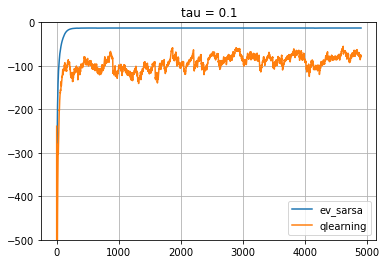

Q-Learning
 >  v  >  >  v  >  v  v  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  v  >  v  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
agent_sarsa = EVSarsaAgentSoftmax(alpha=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions), tau=0.1)

agent_ql = QLearningAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("tau = %s" % agent_sarsa.tau)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

EVSARSA mean reward = -19.44
QLEARNING mean reward = -87.15


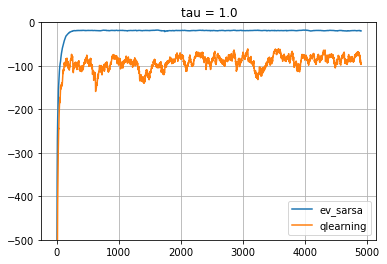

Q-Learning
 <  >  >  >  >  >  v  >  >  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
agent_sarsa = EVSarsaAgentSoftmax(alpha=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions), tau=1.0)

agent_ql = QLearningAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("tau = %s" % agent_sarsa.tau)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

EVSARSA mean reward = -73.49
QLEARNING mean reward = -86.54


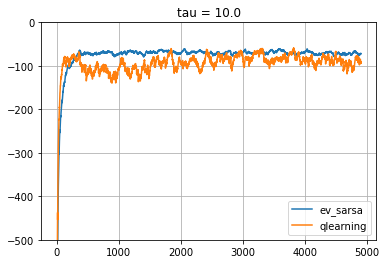

Q-Learning
 >  v  v  >  >  v  >  >  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
agent_sarsa = EVSarsaAgentSoftmax(alpha=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions), tau=10.0)

agent_ql = QLearningAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("tau = %s" % agent_sarsa.tau)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

EVSARSA mean reward = -608.33
QLEARNING mean reward = -69.03


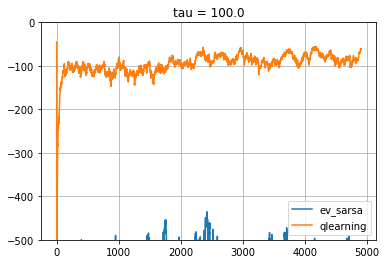

Q-Learning
 >  >  >  v  >  >  >  v  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
agent_sarsa = EVSarsaAgentSoftmax(alpha=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions), tau=100.0)

agent_ql = QLearningAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("tau = %s" % agent_sarsa.tau)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Decreasing $\tau$ while training seems promising, but does not outperform a constant 0.1 value. Maybe different schedulers could be tested to make use of this approach

EVSARSA mean reward = -17.0
QLEARNING mean reward = -84.03


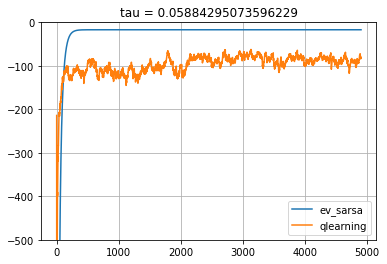

Q-Learning
 >  v  >  >  >  >  >  >  v  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  v  v  v  v  v 
 ^  ^  >  >  >  ^  ^  >  >  v  v  v 
 ^  ^  ^  ^  ^  ^  ^  ^  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


In [ ]:
initial_tau = 0.5
agent_sarsa = EVSarsaAgentSoftmax(alpha=0.25, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions), tau=10.0)

agent_ql = QLearningAgent(alpha=0.25, epsilon=epsilon, discount=0.99,
                              get_legal_actions=lambda s: range(n_actions))

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    agent_sarsa.tau = initial_tau / np.log1p(i)
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant
    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("tau = %s" % agent_sarsa.tau)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

## Part II: experience replay (4 points)

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer. 
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

In [ ]:
import random
import queue


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = np.ndarray(size, dtype=object)
        self._maxsize = size
        self._curr_size = 0
        self.index = 0

    def __len__(self):
        return self._curr_size

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        self._storage[self.index] = data
        self.index = (self.index + 1) % self._maxsize
        self._curr_size = min(self._curr_size + 1, self._maxsize)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        size = self.__len__()
        #idxes = np.random.choice(np.arange(size), size=min(size, batch_size))
        idxes = np.random.choice(np.arange(size), size=batch_size, 
                                 replace=size < batch_size)

        batch = self._storage[idxes]

        # collect <s,a,r,s',done> for each index
        states, actions, rewards, next_states, is_done = zip(*batch)

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(is_done),
        )

Some tests to make sure your buffer works right

In [ ]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])

def obj2sampled(obj):
    return tuple(obj2arrays(obj))

replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(1) == obj2sampled(obj1), \
    "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Success!


Now let's use this buffer to improve training:

In [ ]:
import gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [ ]:
def play_and_train_with_replay(env, agent, replay=None,
                               t_max=10**4, replay_batch_size=32):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        # update agent on current transition. Use agent.update
        agent.update(s, a, r, next_s)

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            replay.add(s, a, r, next_s, done)

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                agent.update(s_[i], a_[i], r_[i], next_s_[i])

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [ ]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

agent_replay = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 9.2
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 6.3


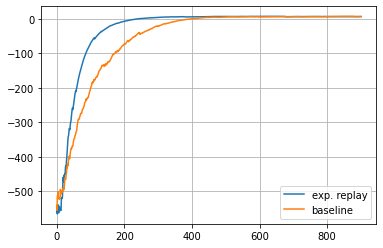

In [ ]:
from IPython.display import clear_output
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(
        play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(
        play_and_train_with_replay(env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('ExpReplay: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='exp. replay')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

### Outro

We will use the code you just wrote extensively in the next week of our course. If you're feeling that you need more examples to understand how experience replay works, try using it for binarized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benifit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.

### Bonus I: TD($\lambda$) (5+ points)

There's a number of advanced algorithms you can find in week 3 materials (Silver lecture II and/or reading about eligibility traces). One such algorithm is TD(lambda), which is based on the idea of eligibility traces. You can also view it as a combination of N-step updates for alll N.
* N-step temporal difference from Sutton's book - [url](http://incompleteideas.net/book/the-book-2nd.html), Chapter 7 (page 142 in the 2020 edition)
* Eligibility traces from Sutton's book - same url, Chapter 12 (page 287)
* Blog post on eligibility traces - [url](http://pierrelucbacon.com/traces/)

Here's a practical algorithm you can start with: [url](https://stackoverflow.com/questions/40862578/how-to-understand-watkinss-q%CE%BB-learning-algorithm-in-suttonbartos-rl-book/40892302)


Implementing this algorithm will prove more challenging than Q-learning or SARSA, but doing so will earn you a deeper understanding of how value-based methods work [in addition to some bonus points].

More kudos for comparing and analyzing TD($\lambda$) against Q-learning and EV-SARSA in different setups (taxi vs cartpole, constant epsilon vs decreasing epsilon).

In [ ]:
from collections import deque

class QLearningAgentNSteps(QLearningAgent):
    def update(self, state, action, rewards, next_state):
        # agent parameters
        discount = 1
        learning_rate = self.alpha

        prev_q = self.get_qvalue(state, action)
        value = self.get_value(next_state)

        cum_reward = 0
        for reward in rewards:
            cum_reward += discount * reward
            discount *= self.discount

        self.set_qvalue(state, action, (1 - learning_rate) * prev_q + 
                        learning_rate * (cum_reward + discount * value) )
        

def play_and_train_n_steps(env, agent, t_max=10**4, n=5):
    total_reward = 0.0
    s = env.reset()
    t_upd = 0
    rewards = deque()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        rewards.append(r)

        if t_upd >= 0:
            agent.update(s, a, rewards, next_s)
            rewards.popleft()


        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

Baseline : eps = 1.079281185266446e-05 mean reward = -13.0
N Steps: eps = 2.9191091959171894e-05 mean reward = 7.2


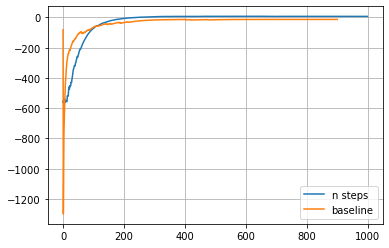

In [ ]:
agent_baseline = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

agent_nsteps = QLearningAgentNSteps(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

rewards_nsteps, rewards_baseline = [], []

for i in range(1000):
    rewards_nsteps.append(
        play_and_train_n_steps(env, agent_nsteps))
    rewards_baseline.append(
        play_and_train(env, agent_baseline))

    agent_nsteps.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('Baseline : eps =', agent_replay.epsilon,
              'mean reward =', np.mean(rewards_baseline[-10:]))
        print('N Steps: eps =', agent_baseline.epsilon,
              'mean reward =', np.mean(rewards_replay[-10:]))
        plt.plot(moving_average(rewards_replay), label='n steps')
        plt.plot(moving_average(rewards_baseline), label='baseline')
        plt.grid()
        plt.legend()
        plt.show()

### Bonus II: More pacman (5+ points)

__see README.md in ```crawler and pacman folder```__

DISCLAIMER - This part is not supported now

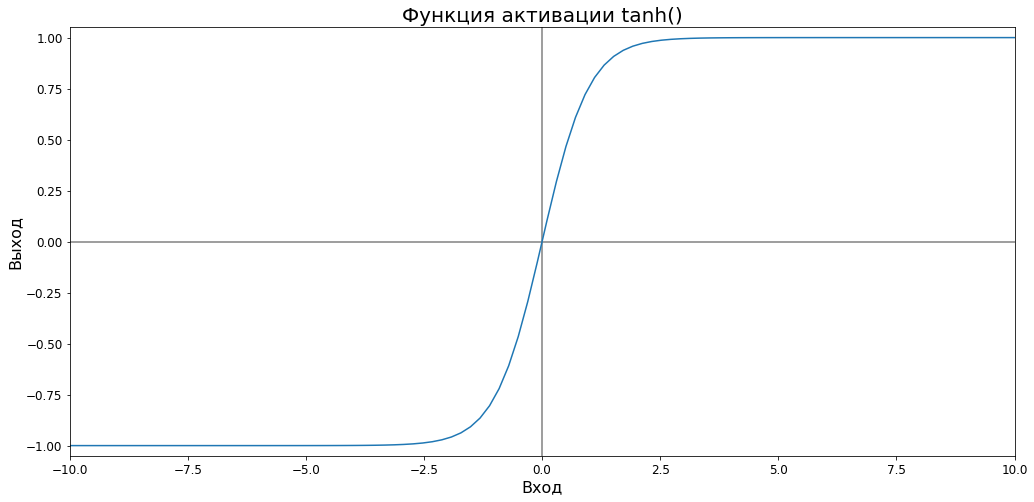

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10, 10, num=100)
y = np.tanh(x)

plt.figure(figsize=(15, 7))
plt.subplots_adjust(left=.075, right=.95, bottom=.1, top=.95)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.title("Функция активации tanh()", )
plt.xlabel("Вход")
plt.ylabel("Выход")
plt.axhline(0,  xmin=-10, xmax=10, color='grey')
plt.axvline(0, ymin=-1, ymax=1, color='grey')
plt.plot(x, y)
plt.xlim(-10, 10)
plt.ylim(-1.05, 1.05)
plt.savefig('tanh.pdf')
plt.savefig('tanh.png')
plt.show()

In [ ]:
import torch
import numpy as np

ranks = np.zeros(1, dtype=int)
i = 0
rank_probs = torch.Tensor([0.1, 0.8, 0.6, 0.35, 0.15, 0.7])
lbl = torch.Tensor([0, 1, 1, 0, 0, 0])
n_chunks = len(rank_probs)
sorted_idx = torch.argsort(rank_probs, descending=True)
ranks[i] = torch.argmax(lbl[sorted_idx] * torch.arange(n_chunks))
print(ranks)

[2]


Text(0.5, 1.0, 'last relevant rank distribution')

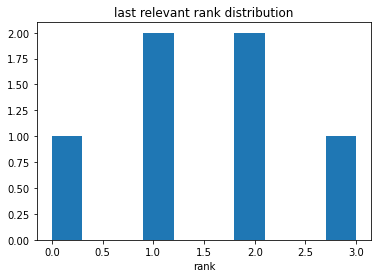

In [ ]:
import matplotlib.pyplot as plt

ranks = np.array([2, 2, 3, 1, 1, 0])
plt.hist(ranks)
plt.xlabel('rank')
plt.title('Last relevant rank distribution')

In [ ]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from time import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import random

In [ ]:
n_samples = 100
X, y = datasets.make_moons(n_samples=n_samples, noise=.095)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

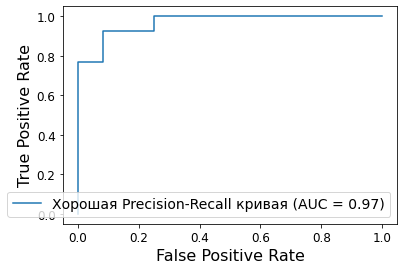

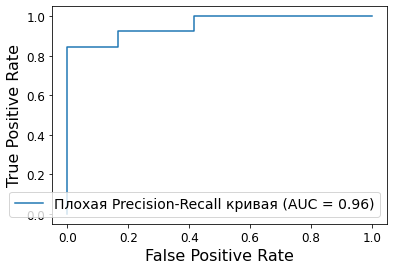

In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)
plot_roc_curve(model, X_test, y_test, name='Хорошая Precision-Recall кривая');
lame_model = LogisticRegression(C=1000)
lame_model.fit(X_train, y_train)
plot_roc_curve(lame_model, X_test, y_test, name='Плохая Precision-Recall кривая');

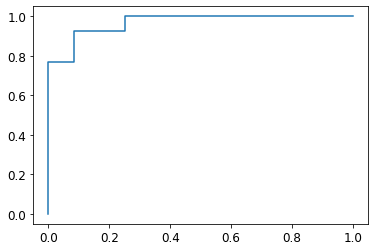

In [ ]:
y_pred = model.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr,
         label='Хорошая ROC кривая (площадь = %0.2f)' % auc(fpr, tpr))

<Figure size 432x432 with 0 Axes>

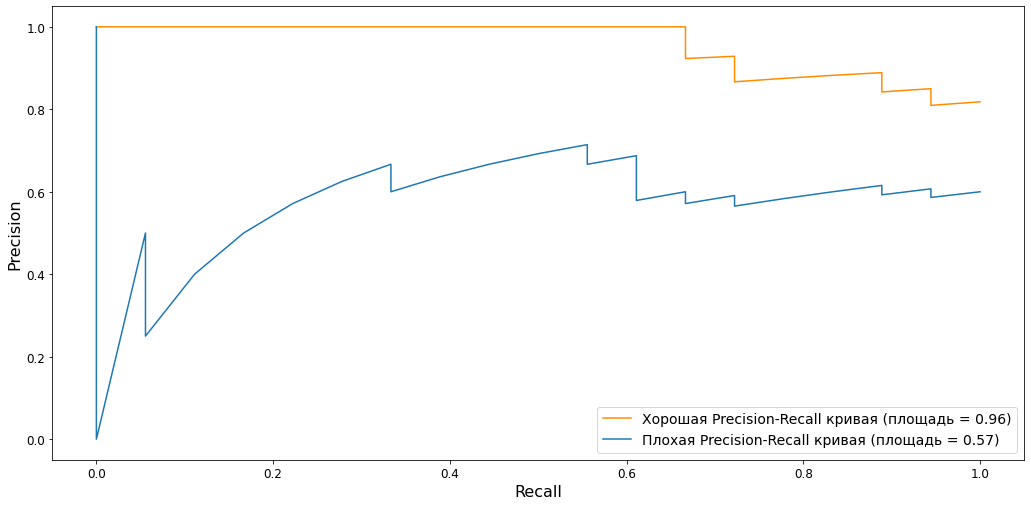

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

#X, y = make_classification(
#    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
#    random_state=42)

X, y = datasets.make_moons(n_samples=n_samples, noise=.095)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
plt.figure(figsize=(6, 6))

X_s = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.3, random_state=42)

svc = LinearSVC(max_iter=5000, tol=1)
svc.fit(X_train, y_train)
y_pred = svc.decision_function(X_test)

pr, rec, thresholds = precision_recall_curve(y_test, np.around(y_pred, 5))

plt.figure(figsize=(15, 7))
plt.subplots_adjust(left=.075, right=.975, bottom=.075, top=.975)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.plot(rec, pr, color='darkorange',
         label='Хорошая Precision-Recall кривая (площадь = %0.2f)' % auc(rec, pr))
plt.legend(loc='lower right')
plt.xlabel('Recall')
plt.ylabel('Precision')


y_rand = [random.uniform(thresholds[0], thresholds[-1]) for _ in range(y_pred.shape[0])]
fpr, tpr, thresholds = roc_curve(y_test, y_rand)

pr, rec, thresholds = precision_recall_curve(y_test, np.around(y_rand, 5))

plt.plot(rec, pr,
         label='Плохая Precision-Recall кривая (площадь = %0.2f)' % auc(rec, pr))
plt.legend(loc='lower right')
plt.savefig('pr.pdf')
plt.savefig('pr.png');


In [ ]:
print(thresholds[0], thresholds[-1])

-0.13903 1.42925


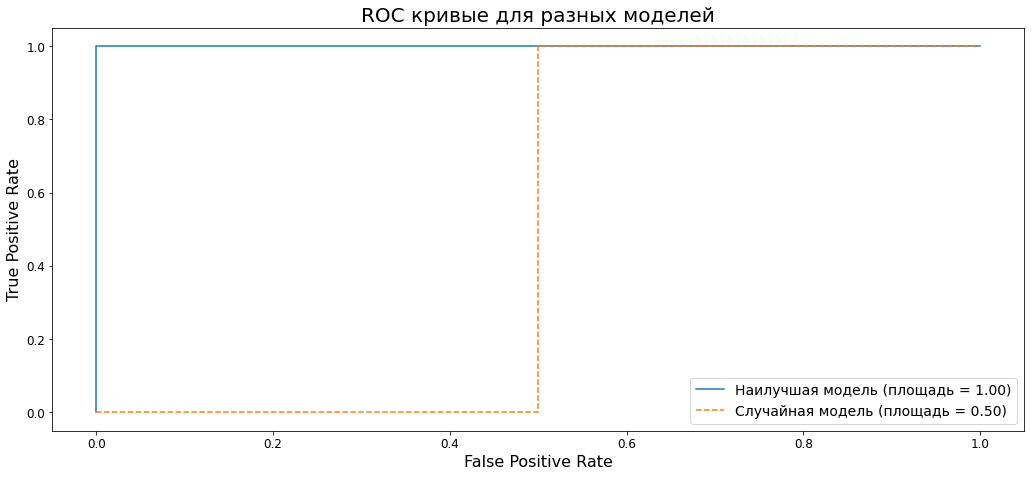

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplots_adjust(left=.075, right=.975, bottom=.1, top=.9)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


y_test = np.array([1, 1, 0, 0, 0])
y_pred = np.array([0.9, 0.8, 0.2, 0.6, 0.1])
y_bad = np.array([0.9, 0.1, 0.7, 0.5, 0.15])
#y_bad = [random.uniform(thresholds[0], thresholds[-1]) for _ in range(y_pred.shape[0])]

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr,
         label='Наилучшая модель (площадь = %0.2f)' % auc(fpr, tpr))

'''
fpr, tpr, thresholds = roc_curve(y_test, y_test)
print(fpr, tpr)

plt.plot(fpr, tpr,
         label='Идеальная ROC кривая (площадь = %0.2f)' % auc(fpr, tpr))
'''

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые для разных моделей')

tpr, fpr, thresholds = roc_curve(y_test, np.around(y_bad, 5))


plt.plot(fpr, tpr,
         label='Случайная модель (площадь = %0.2f)' % auc(fpr, tpr), ls='--')
plt.legend(loc='lower right')
plt.savefig('roc.pdf')
plt.savefig('roc_simple.png');


In [ ]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
#df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')
#df = df.drop('duration', axis=1)
#X, y = df.drop('y', axis=1), df['y'].map({'no': 0, 'yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

In [ ]:
numeric = X_train._get_numeric_data().columns
categorical = X_train.dtypes[X_train.dtypes == "object"].index

from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('encoding', column_transformer),
    ('regression', LogisticRegression(max_iter=1000))
])

start = time()
model = pipeline.fit(X_train, y_train)
end = time()

y_pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)

print('Время, потребовавшееся на обучение: ', round(end - start, 3), 'с.', sep='')
print('ROC-AUC =', round(roc_auc, 5))

Время, потребовавшееся на обучение: 2.788с.
ROC-AUC = 0.78817


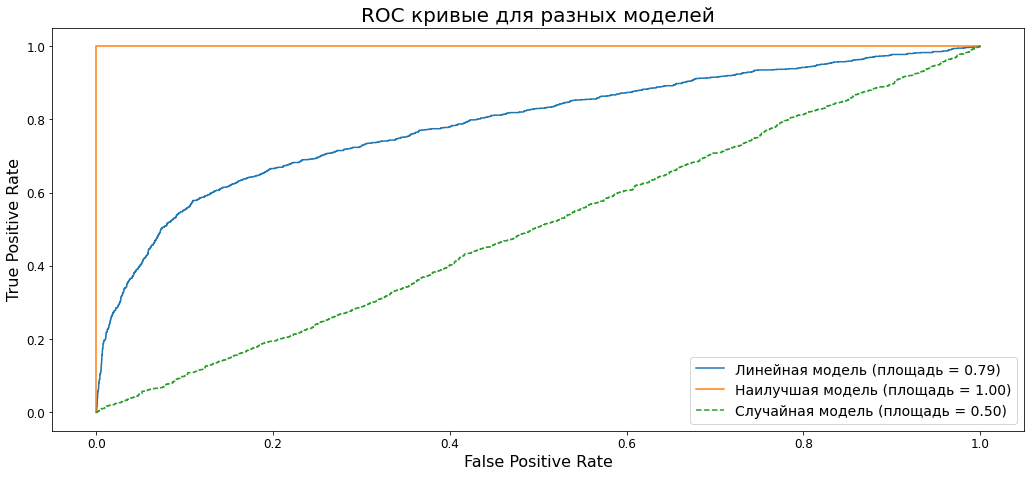

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplots_adjust(left=.075, right=.975, bottom=.1, top=.9)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


#y_test = np.array([1, 1, 0, 0, 0])
#y_pred = np.array([0.9, 0.8, 0.2, 0.6, 0.1])
#y_bad = np.array([0.9, 0.1, 0.7, 0.5, 0.15])

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr,
         label='Линейная модель (площадь = %0.2f)' % auc(fpr, tpr))


fpr, tpr, thresholds = roc_curve(y_test, y_test)

plt.plot(fpr, tpr,
         label='Наилучшая модель (площадь = %0.2f)' % auc(fpr, tpr))


plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые для разных моделей')

y_bad = [random.uniform(thresholds[0], thresholds[-1]) for _ in range(y_pred.shape[0])]
tpr, fpr, thresholds = roc_curve(y_test, np.around(y_bad, 5))

plt.plot(fpr, tpr,
         label='Случайная модель (площадь = %0.2f)' % auc(fpr, tpr), ls='--')
plt.legend(loc='lower right')
plt.savefig('roc.pdf')
plt.savefig('roc_complex.png');
